In [1]:
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Activation
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import itertools
from tqdm import tqdm
import feat_eng

%matplotlib inline

Using TensorFlow backend.


## Load files

In [2]:
train = pd.read_csv('./train.csv')
label = pd.read_csv('./challenge_output_data_training_file_nba_challenge.csv', sep=';')
train = pd.merge(train, label, on='ID')

train = feat_eng.add_tot_rebounds(train)
train = feat_eng.add_fg(train)
df_train, df_val = train_test_split(train, test_size=0.2, random_state=42)

test = pd.read_csv('./test.csv')

print(df_train.shape, df_val.shape)

100%|██████████| 1440/1440 [03:27<00:00,  6.93it/s]

(10060, 21602) (2516, 21602)


## XGBoost

In [3]:
y_train = df_train.label.values
X_train = df_train.drop(['ID', 'label'], axis=1)

y_val = df_val.label.values
X_val = df_val.drop(['ID', 'label'], axis=1)

In [4]:
# base parameters
#XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
#       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
#       max_depth=10, min_child_weight=1, missing=None, n_estimators=100,
#       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
#       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
#       silent=True, subsample=1)

params = {'base_score':0.98,
                'booster':'gbtree', 
                'colsample_bylevel':0.7,
                'colsample_bytree':1,
                'learning_rate':0.1,
                'min_child_weight':10,
                'max_delta_step':1,
                'max_depth':20,
                'n_estimators':100}

In [5]:
# machine learning: XGB
from xgboost import XGBClassifier

# fit model no training data
model = XGBClassifier(**params)
model.fit(X_train, y_train)

XGBClassifier(base_score=0.98, booster='gbtree', colsample_bylevel=0.7,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=1,
       max_depth=20, min_child_weight=10, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [6]:
# make predictions for validation data
y_pred = model.predict(X_val)
np.mean(y_pred == y_val) #0.735

0.73489666136724963

## Output on Test

In [15]:
test = pd.read_csv('./test.csv')
test = feat_eng.add_tot_rebounds(test)
test = feat_eng.add_fg(test, test=True)
X_test = test.drop(['ID'], axis=1)

100%|██████████| 1440/1440 [00:23<00:00, 61.19it/s]


In [16]:
test['label'] = model.predict(X_test)
test[['ID', 'label']].to_csv('pred_xgboost_opt_raw.csv', index=False)

In [17]:
feat_names = X_train.columns[np.argsort(model.feature_importances_)[::-1]]
feat = np.sort(model.feature_importances_)[::-1]

In [18]:
all_features = set([k.split('_')[0] for k in feat_names])
feat_min_idx = sorted([min([i for i,k in enumerate(feat_names) if k.split('_')[0] == feat]) for feat in all_features])
feat_names2 = feat_names[feat_min_idx]
feat2 = feat[feat_min_idx]

In [19]:
def correct_label(x):
    x = x.replace('_','\n')
    x = x.replace("defensive", 'def')
    x = x.replace('offensive', 'off')
    return x.replace('total', '')

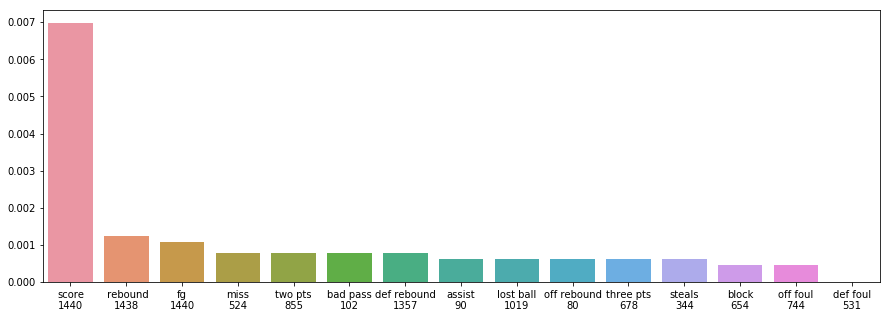

In [20]:
f, ax = plt.subplots(figsize=(15,5))
sns.barplot(x=feat_names2, y=feat2, order=feat_names2)
_=ax.set_xticklabels([correct_label(k.get_text()) for k in ax.get_xticklabels()])

In [ ]:
# evaluation metric - public accuracy : score_function
def score_function(y_true, y_pred):
    score = 0
    length1 = y_true.shape[0]
    for i in range(length1):
        if y_pred[i] == y_true[i]:
            score += 1
    return float(score)/float(length1)

#error = score_function(y_test.values, yhat)